<a href="https://colab.research.google.com/github/bakarin/DogBreed-Image-Classifier/blob/master/DogBreed_Classifier_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Classification with Transfer Learning in TensorFlow


## Imports

In [277]:
%tensorflow_version 2.x # Befehl für Google Colab für Tensorflow 2
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # Befehl für Google Colab für Tensorflow 2`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
import numpy as np
import cv2                
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, \
  Conv2D, MaxPooling2D, Flatten, BatchNormalization, GaussianNoise, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

## Helpers

Load the following helper functions via the  `deeplearning2020` python package:

- def plot_learning_curve(title, x, y, y_test, ylim=0.6)
- def plot_history(title, history, ylim=0.6)
- def plot_images(images, labels)

helper functions [source](https://github.com/into-ai/deeplearning2020/blob/master/deeplearning2020/helpers.py)

In [279]:
!pip install --upgrade deeplearning2020
from deeplearning2020 import helpers

Requirement already up-to-date: deeplearning2020 in /usr/local/lib/python3.6/dist-packages (0.4.21)


## Load Dataset

Imagewoof is a subset of 10 classes from Imagenet that are all dog breeds. The breeds are: Australian terrier, Border terrier, Samoyed, Beagle, Shih-Tzu, English foxhound, Rhodesian ridgeback, Dingo, Golden retriever, Old English sheepdog.

In [280]:
from deeplearning2020.datasets import ImageWoof
train_data_raw, test_data_raw, classes = ImageWoof.load_data()

/root/.keras/datasets/imagewoof2-320/train
Loaded 9025 images
/root/.keras/datasets/imagewoof2-320/val
Loaded 3929 images


In [281]:
# number of classes
classes.shape

(10,)

In [282]:
# classes
n_classes = classes.shape[0]
print(classes)

['Shih-Tzu' 'Rhodesian ridgeback' 'Beagle' 'English foxhound'
 'Border terrier' 'Australian terrier' 'Golden retriever'
 'Old English sheepdog' 'Samoyed' 'Dingo']


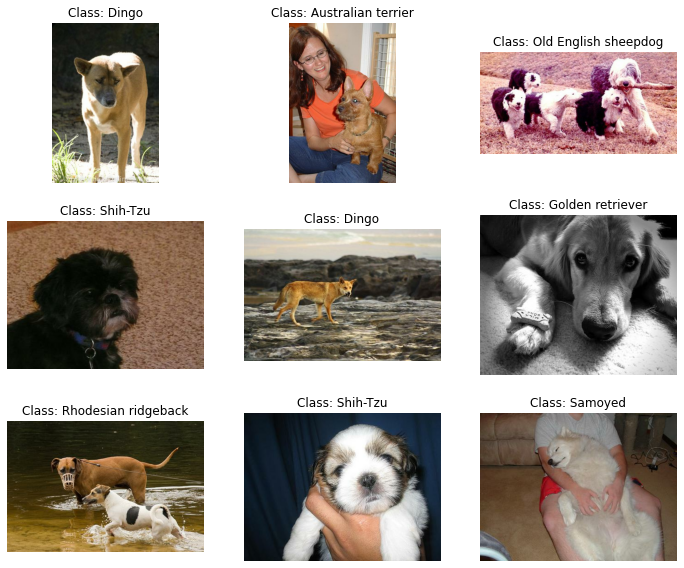

In [283]:
# display 9 sample images from the train set
helpers.plot_images(train_data_raw.take(9), classes)

In [284]:
# check the array of one training data sample
for image, label in train_data_raw.take(1): 
    print(image.numpy())

[[[0.         0.00392157 0.        ]
  [0.02352941 0.02745098 0.00392157]
  [0.04313726 0.02745098 0.        ]
  ...
  [0.         0.04313726 0.        ]
  [0.         0.04313726 0.        ]
  [0.         0.03529412 0.        ]]

 [[0.         0.00784314 0.        ]
  [0.30588236 0.3019608  0.28235295]
  [0.5372549  0.52156866 0.4784314 ]
  ...
  [0.34901962 0.49411768 0.36078432]
  [0.16470589 0.28235295 0.17254902]
  [0.         0.0509804  0.        ]]

 [[0.03529412 0.03921569 0.01960784]
  [0.5411765  0.5411765  0.50980395]
  [0.93725497 0.91372555 0.86666673]
  ...
  [0.48235297 0.7725491  0.57254905]
  [0.19215688 0.454902   0.28235295]
  [0.         0.09411766 0.        ]]

 ...

 [[0.         0.0627451  0.        ]
  [0.21960786 0.37254903 0.26666668]
  [0.32941177 0.58431375 0.4156863 ]
  ...
  [0.29411766 0.5529412  0.37254903]
  [0.25882354 0.41960788 0.3019608 ]
  [0.         0.05882353 0.        ]]

 [[0.03921569 0.04313726 0.01960784]
  [0.16470589 0.21960786 0.16078432]


## Preprocessing
 Resize all images to 299 x 299 pixels and run them through Xceptions preprocessing function. We are normalizing them from their original range from 0 to 1 to 0 to 255 as this is the required input format for Xception.


In [0]:

def preprocess(image, label='default'):
  '''standard preprocessing function'''
  # resize the images to a uniform size
  resized_image = tf.image.resize(image*255, [224, 224])
  
  # run Xceptions preprocessing function
  preprocessed_image = tf.keras.applications.xception.preprocess_input(resized_image)
  
  return preprocessed_image, label


def preprocess_with_data_augmentation(image, label):
  '''alternative preprocessing function with data augmentation'''
  # resize the images to a uniform size
  resized_image = tf.image.resize(image*255, [224, 224])

  # data augmentation with Tensorflow
  augmented_image = tf.image.random_flip_left_right(resized_image)
  #augmented_image = tf.image.random_hue(augmented_image, 0.08)
  #augmented_image = tf.image.random_saturation(augmented_image, 0.6, 1.6)
  #augmented_image = tf.image.random_brightness(augmented_image, 0.05)
  #augmented_image = tf.image.random_contrast(augmented_image, 0.7, 1.3)

  # run Xceptions preprocessing function
  preprocessed_image = tf.keras.applications.xception.preprocess_input(augmented_image)
  
  return preprocessed_image, label

Apply `preprocess` function to all data

`.batch` prepares the next batch of the specified batch_size

`.prefetch` loads the next batch into memory


In [286]:
batch_size = 32 
train_data = train_data_raw.shuffle(1000) 
print('train_data shape before preprocessing: ', train_data)
# data augmentation on train data
train_data = train_data_raw.map(preprocess_with_data_augmentation).batch(batch_size).prefetch(1)          
print('train_data shape after preprocessing: ', train_data)

# no data augmentation on test data
test_data = test_data_raw.map(preprocess).batch(batch_size).prefetch(1)


train_data shape before preprocessing:  <ShuffleDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
train_data shape after preprocessing:  <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


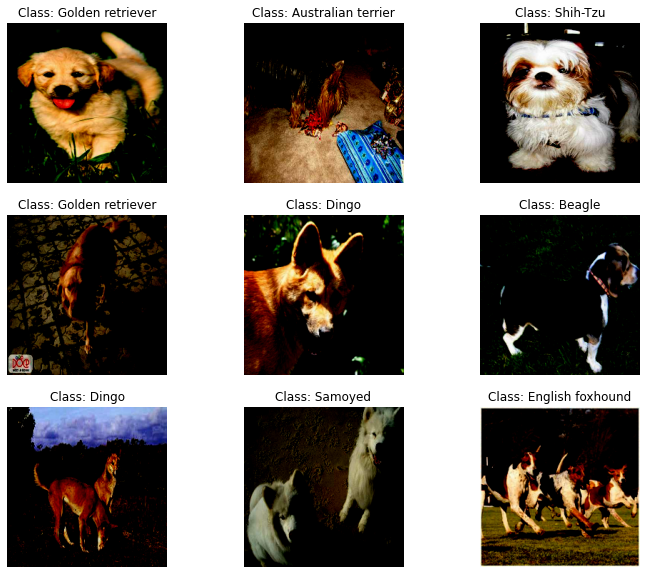

In [287]:
# display 9 sample images from the train set after pre-processing
helpers.plot_images(train_data.unbatch().take(9), classes) 

## Model Definition

- Use a pretrained Xception model without its original classifier
- make a new fully-connected classifier with the correct number of classes for our case and dense_neurons=1000
- include 50 % dropout 
- Output Function with `softmax` activation



In [0]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

# build a transfer learning model with Xception and a new Fully-Connected-Classifier
# by setting include_top to False to remove original classifier and defining a new output_layer
base_model = Xception(weights='imagenet',
                      include_top=False)

model = GlobalAveragePooling2D()(base_model.output)
model = Dropout(0.5)(model)

# include new Fully-Connected-Classifier
output_layer = Dense(n_classes, activation='softmax')(model)

# create Model
model = Model(base_model.input, output_layer)

In [0]:
# uncomment for a look at the model architecture
# model.summary()

In [0]:
# set the pretrained layers to not trainable because
# there are already trained and we don't want to destroy
# their weights
for layer in base_model.layers:
  layer.trainable = False

In [0]:
#model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01),
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Model Training

In [292]:
history = model.fit(train_data,
                    epochs=5,
                    validation_data=test_data)

Epoch 1/5
283/283 [==============================] - 31s 111ms/step - loss: 1.1393 - accuracy: 0.7022 - val_loss: 0.4470 - val_accuracy: 0.9254
Epoch 2/5
283/283 [==============================] - 30s 108ms/step - loss: 0.3803 - accuracy: 0.9163 - val_loss: 0.2746 - val_accuracy: 0.9318
Epoch 3/5
283/283 [==============================] - 31s 108ms/step - loss: 0.2696 - accuracy: 0.9288 - val_loss: 0.2279 - val_accuracy: 0.9354
Epoch 4/5
283/283 [==============================] - 31s 108ms/step - loss: 0.2233 - accuracy: 0.9352 - val_loss: 0.2085 - val_accuracy: 0.9371
Epoch 5/5
283/283 [==============================] - 31s 108ms/step - loss: 0.2052 - accuracy: 0.9392 - val_loss: 0.1986 - val_accuracy: 0.9376


## Model Performance Evaluation

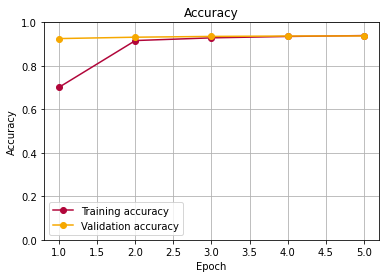

In [293]:
helpers.plot_history('Accuracy', history, 0)

In [294]:
eval_loss, eval_accuracy = model.evaluate(test_data, verbose=False)
print("Model accuracy: %.2f" % eval_accuracy)

Model accuracy: 0.94


## Model Finetuning

In [295]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [0]:
# to finetune the model, we have to set more layers (but perhaps not all)
# to trainable and reduce the learning rate drastically
# to prevent destroying of weights
# we choose to unfreeze the last 2 only
for layer in base_model.layers[-2:]:
  layer.trainable = True

In [297]:
# reduce the learning rate to not damage the pretrained weights
# model will need longer to train because more layers are trainable
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_finetune=model.fit(
    train_data,
    epochs=10,
    validation_data=test_data
)

Epoch 1/10
283/283 [==============================] - 31s 111ms/step - loss: 0.2173 - accuracy: 0.9383 - val_loss: 0.1843 - val_accuracy: 0.9410
Epoch 2/10
283/283 [==============================] - 31s 108ms/step - loss: 0.1866 - accuracy: 0.9429 - val_loss: 0.1768 - val_accuracy: 0.9415
Epoch 3/10
283/283 [==============================] - 31s 108ms/step - loss: 0.1725 - accuracy: 0.9465 - val_loss: 0.1766 - val_accuracy: 0.9425
Epoch 4/10
283/283 [==============================] - 31s 108ms/step - loss: 0.1636 - accuracy: 0.9491 - val_loss: 0.1756 - val_accuracy: 0.9427
Epoch 5/10
283/283 [==============================] - 31s 108ms/step - loss: 0.1596 - accuracy: 0.9506 - val_loss: 0.1739 - val_accuracy: 0.9407
Epoch 6/10
283/283 [==============================] - 31s 108ms/step - loss: 0.1557 - accuracy: 0.9502 - val_loss: 0.1744 - val_accuracy: 0.9425
Epoch 7/10
283/283 [==============================] - 31s 108ms/step - loss: 0.1449 - accuracy: 0.9529 - val_loss: 0.1716 - val_ac

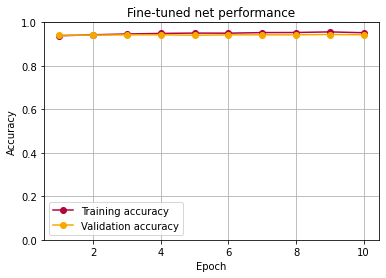

In [298]:
helpers.plot_history('Fine-tuned net performance', history_finetune, 0)

## Model Inference (Make Predictions)
1. upload any image
2. convert image to numpy array
3. pass image through pre-processing
4. add a dimension to the array to make it compatible with the 4D dimension requirement of the model: the newaxis expression is used to increase the dimension of the existing array by one more dimension
5. pass array through model.predict() and output the index / class_name of the class with highest probability

In [0]:
def predict_dog(img_name):
  '''pre-processes an input image to the required format and then 
  runs it through the model prediction to predict its class 
  INPUT: image file name (image must be in same path)
  OUTPUT: display the image with its prediction next to
  an image of the predicted class from the training set
  '''
  # convert to numpy array
  img = plt.imread(img_name)
  #print("image shape before preprocessing: ", img.shape)

  # pre-process
  image, label = preprocess(img)
  #print("image shape after preprocessing: ", image.shape)

  # add new axis (for batch)
  image = image[np.newaxis, :]
  #print("image shape with additional dimension: ", image.shape)

  # make prediction
  result = model.predict(image) # alternative: model(image, training=False)
  class_index = np.argmax(result)
  class_name = classes[class_index]
  class_prob = np.max(result, axis=1)[0]*100

  #print output
  print("The breed of dog is most likely a {}.".format(class_name))
  print("The probability is %.2f percent." % class_prob)

  # display the image next to a random example of this class from the train set
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.title(img_name)
  plt.axis('off')
  plt.subplot(1, 2, 2)
  for pic, label in train_data_raw.take(100):
    if label == class_index:
      plt.imshow(pic)
      plt.title(classes[label])
      plt.axis('off')
  
  return

The breed of dog is most likely a English foxhound.
The probability is 21.37 percent.


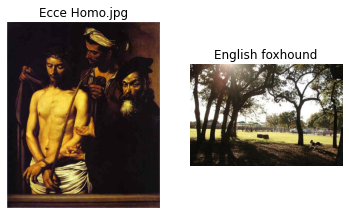

In [302]:
predict_dog('Ecce Homo.jpg')